In [1]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
import sys 
import utils
%matplotlib inline

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

In [2]:
# lbl_path = '/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed/Training_pre/HGG/seg/BraTS20_Training_001_seg.npy'
# lbl = np.load(lbl_path)
# print(lbl.shape)
# print("Labels in segmentation image: {}".format(np.unique(lbl)))

In [3]:
# lbl = tf.where(lbl==4,3,lbl)
# lbl_sparse = tf.keras.utils.to_categorical(lbl, num_classes=4)
# print(lbl_sparse.shape)

# plt.imshow(np.squeeze(np.sum(lbl_sparse,-1)[:,:,45]), cmap ='gray')

In [4]:
# lbl_sparse_max = tf.math.argmax(lbl_sparse,-1)
# plt.imshow(np.squeeze(lbl_sparse_max[:,:,50]), cmap='gray')

---

# Hyperparameter

In [5]:
SHUFFLE_BUFFER = 4000
BATCH_SIZE = 16
lr = 0.0000002
opt = tf.keras.optimizers.Adam(lr)
tfrecords_read_dir = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords/HGG/'

---

# Helper Functions

In [6]:
def dicesq(y_true, y_pred):
    '''
    Modified dice coefficient as refer to: https://arxiv.org/abs/1606.04797
    :param y_true: Ground truth
    :param y_pred: Prediction from the model
    :return: Modified dice coefficient
    '''
    nmr = 2*tf.reduce_sum(y_true*y_pred)
    dnmr = tf.reduce_sum(y_true**2) + tf.reduce_sum(y_pred**2) + tf.keras.backend.epsilon()
    return (nmr / dnmr)

def dicesq_loss(y_true, y_pred):
    '''
    Modified dice coefficient loss
    :param y_true: Ground truth
    :param y_pred: Prediction from the model
    '''
    return 1- dicesq(y_true, y_pred)

def dice_coef(y_true, y_pred):
    '''
    Dice coefficient for tensorflow
    '''
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + tf.keras.backend.epsilon()) / \
(tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + tf.keras.backend.epsilon())

def dice_coe(target, output, axis=(1, 2, 3), smooth=1e-5):
    """Soft dice (Sørensen or Jaccard) coefficient for comparing the similarity
    of two batch of data, usually be used for binary image segmentation
    i.e. labels are binary. The coefficient between 0 to 1, 1 means totally match.

    Parameters
    -----------
    output : Tensor
        A distribution with shape: [batch_size, ....], (any dimensions).
    target : Tensor
        The target distribution, format the same with `output`.
    loss_type : str
        ``jaccard`` or ``sorensen``, default is ``jaccard``.
    axis : tuple of int
        All dimensions are reduced, default ``[1,2,3]``.
    smooth : float
        This small value will be added to the numerator and denominator.
            - If both output and target are empty, it makes sure dice is 1.
            - If either output or target are empty (all pixels are background), dice = ```smooth/(small_value + smooth)``, then if smooth is very small, dice close to 0 (even the image values lower than the threshold), so in this case, higher smooth can have a higher dice.

    Examples
    ---------
    >>> import tensorlayer as tl
    >>> outputs = tl.act.pixel_wise_softmax(outputs)
    >>> dice_loss = 1 - tl.cost.dice_coe(outputs, y_)

    References
    -----------
    - `Wiki-Dice <https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient>`__
    https://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/cost.html
    """
    inse = tf.reduce_sum(output * target, axis=axis)
    l = tf.reduce_sum(output * output, axis=axis)
    r = tf.reduce_sum(target * target, axis=axis)
    dice = (2. * inse + smooth) / (l + r + smooth)
    dice = tf.reduce_mean(dice)
    return dice

def dice_coef_loss(y_true, y_pred):
    '''
    Dice coefficient loss for IOU
    '''
    return 1-dice_coe(y_true, y_pred)

def plot_comparison(input_img, caption, n_row=1, n_col=2, figsize=(10, 10), cmap = 'gray'):
    '''
    Plot comparison of multiple image but only in column wise!
    :param input_img: Input image list
    :param caption: Input caption list
    :param IMG_SIZE: Image size
    :param n_row: Number of row is 1 by DEFAULT
    :param n_col: Number of columns
    :param figsize: Figure size during plotting
    :return: Plot of (n_row, n_col)
    '''
    print()
    assert len(caption) == len(input_img), "Caption length and input image length does not match"
    assert len(input_img) == n_col, "Error of input images or number of columns!"

    fig, axes = plt.subplots(n_row, n_col, figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.4, right=0.7)

    for i in range(n_col):
        axes[i].imshow(np.squeeze(input_img[i]), cmap= cmap)
        axes[i].set_xlabel(caption[i])
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    plt.tight_layout()
    plt.show()

----

# Model

In [7]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from coord_conv import CoordConv

def conv_block(x_in, filters, batch_norm = False, kernel_size=(3,3)):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm==True:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    if batch_norm==True:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def coordconv_block(x_in, x_dim, y_dim, filters, batch_norm = False, kernel_size=(3,3), with_r = False):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm==True:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = CoordConv(x_dim, y_dim, with_r, filters, kernel_size, padding='same')(x)
    if batch_norm==True:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def conv_2d(x_in, filters, batch_norm = False, kernel_size=(3,3),acti ='relu'):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm==True:
        x=BatchNormalization()(x)
    x= Activation(acti)(x)
    return x
    
def pool(x_in, pool_size=(2, 2), type='Max'):
    if type=='Max':
        p = MaxPooling2D(pool_size)(x_in)
    return p

def up(x_in, filters, merge, batch_norm = False, size=(2,2)):
    u = UpSampling2D(size)(x_in)
    conv = conv_2d(u, filters, batch_norm)
    concat = tf.concat([merge, conv],axis=-1)
    return concat
    
def Unet_model(input_layer):
    #downsampling
#     conv1 = coordconv_block(input_layer, x_dim=240, y_dim=240, filters=64)
    conv1 = conv_block(input_layer, filters=64)
    pool1 = pool(conv1)
    
    conv2 = conv_block(pool1, filters=128)
    pool2 = pool(conv2)
    
    conv3 = conv_block(pool2, filters=256)
    pool3 = pool(conv3)
    
    conv4 = conv_block(pool3, filters=512)
    pool4 = pool(conv4)
    
    conv5 = conv_block(pool4, filters=1024)
    
    #upsampling
    up1 = up(conv5,filters=512, merge=conv4)
#     conv6 = coordconv_block(up1, x_dim=30, y_dim=30, filters=512)
    conv6 = conv_block(up1, filters=512)
    
    up2 = up(conv6, filters=256, merge=conv3)
    conv7 = conv_block(up2, filters=256)
    
    up3 = up(conv7, filters=128, merge=conv2)
    conv8 = conv_block(up3, filters=128)
    
    up4 = up(conv8, filters=64, merge=conv1)
    conv9 = conv_block(up4, filters=64)
    
    #on paper filters = 2
    output_layer = conv_2d(conv9, filters=4, kernel_size=(1,1), acti='softmax')
    
    return output_layer

In [8]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

input_layer = Input(shape=(240,240,1))
Unet = Model(input_layer, Unet_model(input_layer))

In [9]:
#to do..Sensitivity
xent = tf.keras.losses.CategoricalCrossentropy()
@tf.function
def train_fn(image, label):
    with tf.GradientTape() as tape:
        model_output = Unet(image)
        loss = xent(label, model_output)
    gradients = tape.gradient(loss, Unet.trainable_variables)
    opt.apply_gradients(zip(gradients, Unet.trainable_variables))
    
    return model_output, loss, gradients

Epochs  1

HGGflair_stack.tfrecords




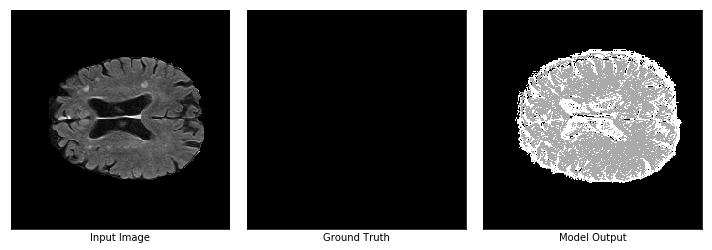

Steps: 100, Loss:1.386203646659851
Gradient min:-0.0030189966782927513, max:0.0029667140915989876



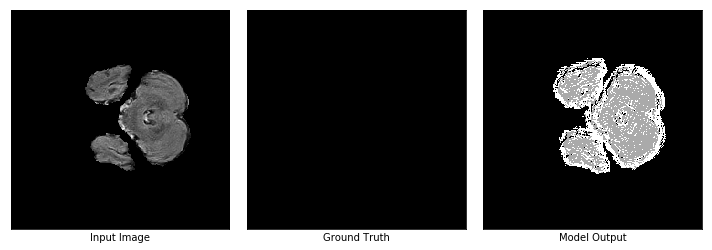

Steps: 200, Loss:1.3854609727859497
Gradient min:-0.0026536837685853243, max:0.0025153448805212975



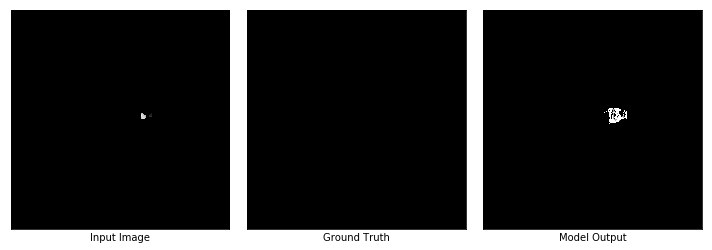

Steps: 300, Loss:1.3846246004104614
Gradient min:-0.003156613325700164, max:0.0029045655392110348



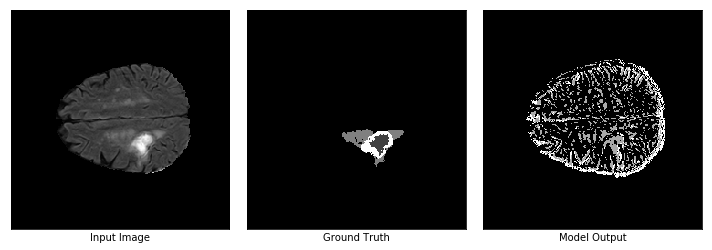

Steps: 400, Loss:1.3834731578826904
Gradient min:-0.0036790657322853804, max:0.0031051093246787786



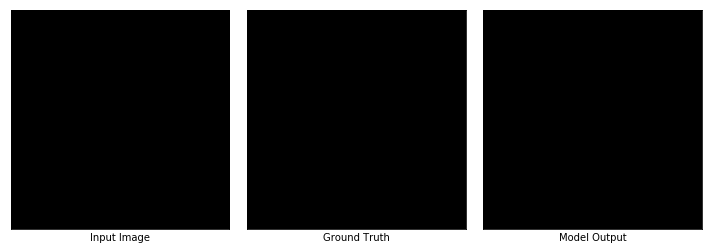

Steps: 500, Loss:1.3821444511413574
Gradient min:-0.003332410240545869, max:0.002527495613321662



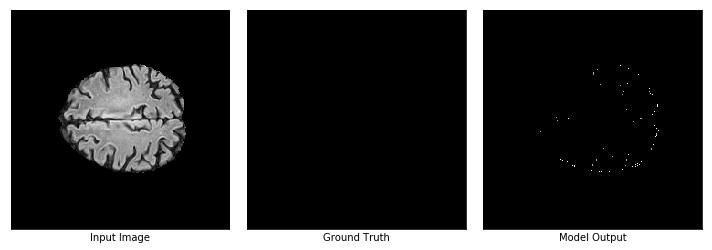

Steps: 600, Loss:1.3777936697006226
Gradient min:-0.004581687971949577, max:0.0038895634934306145



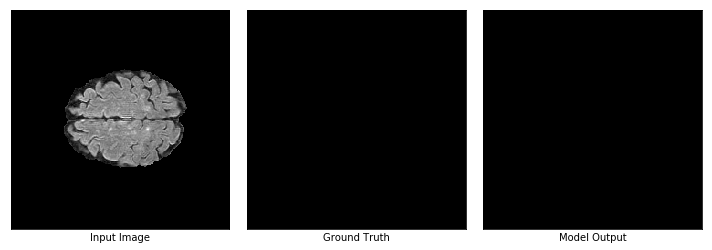

Steps: 700, Loss:1.364702820777893
Gradient min:-0.008677893318235874, max:0.0047246720641851425



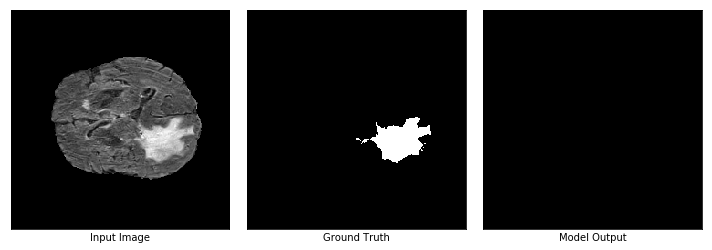

Steps: 800, Loss:1.2991245985031128
Gradient min:-0.03395841270685196, max:0.013148773461580276



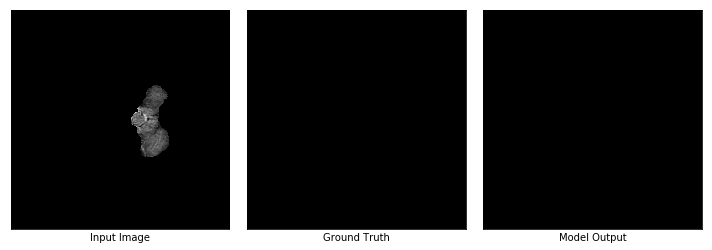

Steps: 900, Loss:1.0213874578475952
Gradient min:-0.11475904285907745, max:0.03507126495242119



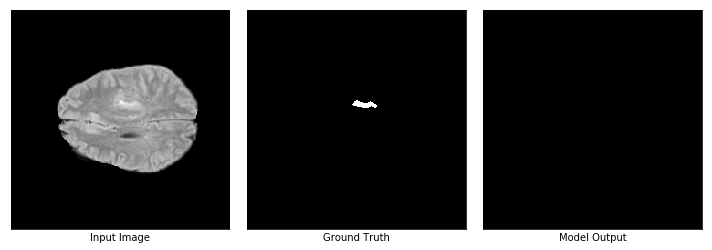

Steps: 1000, Loss:0.696557879447937
Gradient min:-0.060066673904657364, max:0.016423996537923813



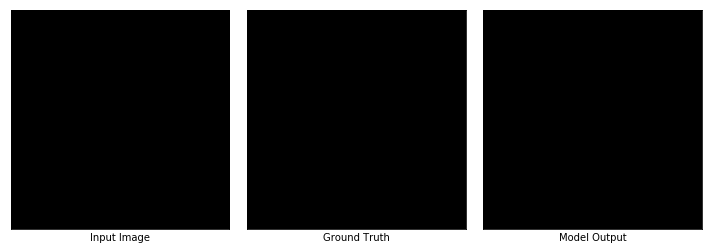

Steps: 1100, Loss:0.5825961232185364
Gradient min:-0.011428614147007465, max:0.024054167792201042



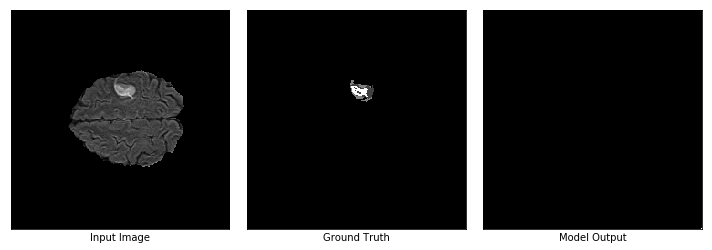

Steps: 1200, Loss:0.3753267824649811
Gradient min:-0.020777059718966484, max:0.0055517940782010555



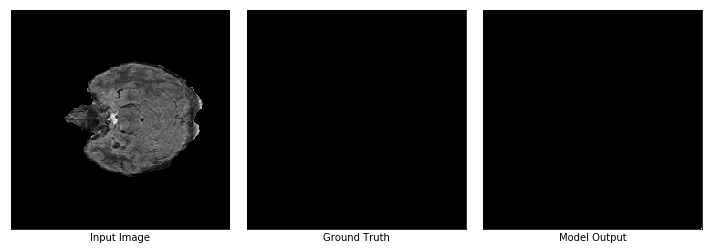

Steps: 1300, Loss:0.22820062935352325
Gradient min:-0.011053873226046562, max:0.0028227106668055058



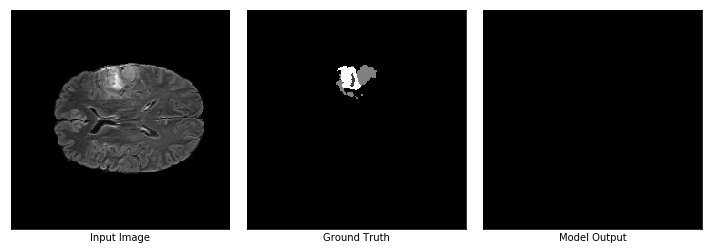

Steps: 1400, Loss:0.26873597502708435
Gradient min:-0.008539781905710697, max:0.0022561654914170504



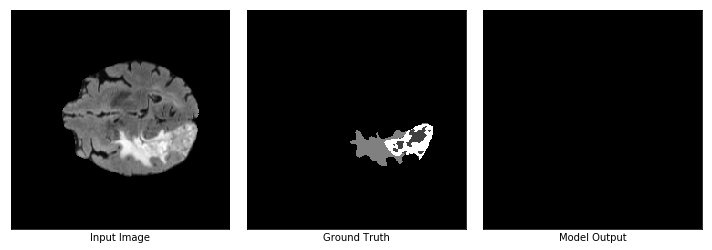

Steps: 1500, Loss:0.15110357105731964
Gradient min:-0.004468417260795832, max:0.00121118628885597



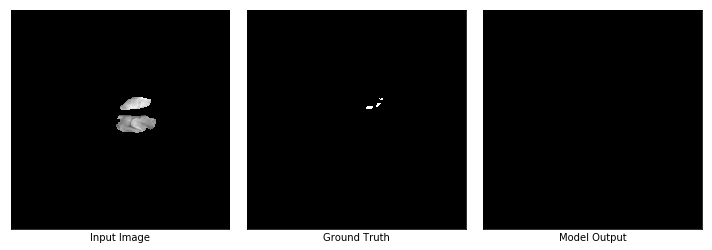

Steps: 1600, Loss:0.2014307975769043
Gradient min:-0.002919259015470743, max:0.0007871307316236198



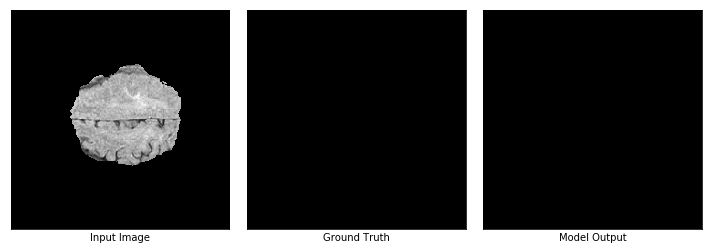

Steps: 1700, Loss:0.16745750606060028
Gradient min:-0.0025225523859262466, max:0.000692147936206311



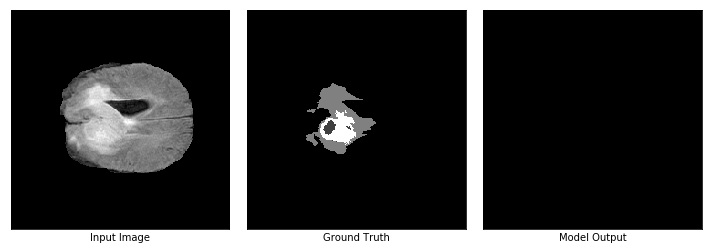

Steps: 1800, Loss:0.2578963339328766
Gradient min:-0.0031548545230180025, max:0.0008536752429790795



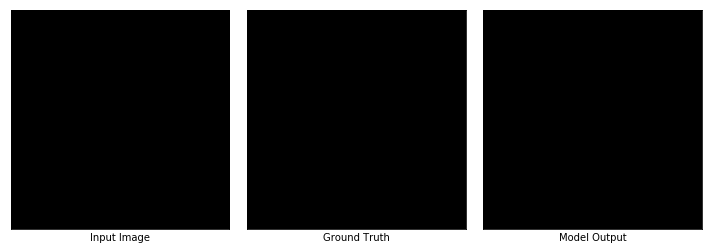

Steps: 1900, Loss:0.167538583278656
Gradient min:-0.0019402554025873542, max:0.0005095945089124143



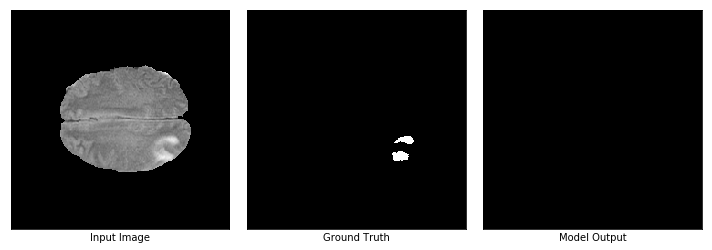

Steps: 2000, Loss:0.20338799059391022
Gradient min:-0.0016764078754931688, max:0.00045089106424711645



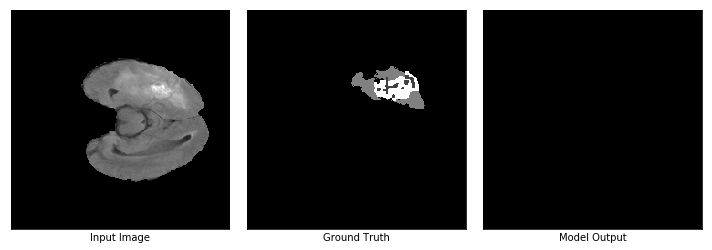

Steps: 2100, Loss:0.3515264093875885
Gradient min:-0.0018452295335009694, max:0.0005037221708334982



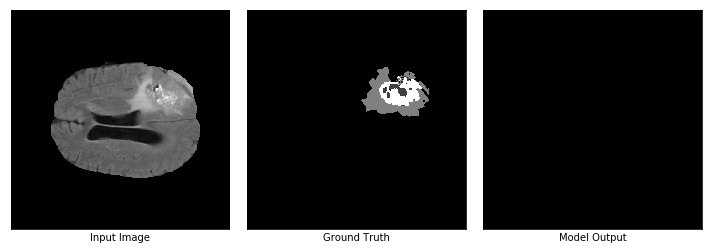

Steps: 2200, Loss:0.32852840423583984
Gradient min:-0.0014529894106090069, max:0.00039681867929175496



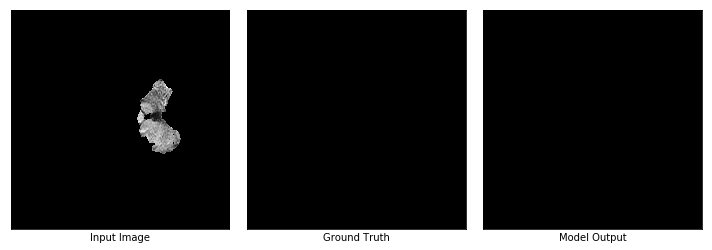

Steps: 2300, Loss:0.07722195237874985
Gradient min:-0.0007309298380278051, max:0.0001980450178962201



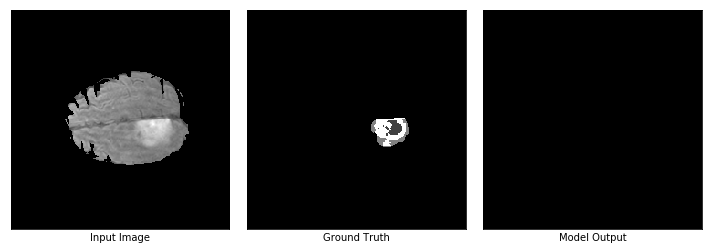

Steps: 2400, Loss:0.24996328353881836
Gradient min:-0.0006319122039712965, max:0.0001766102504916489



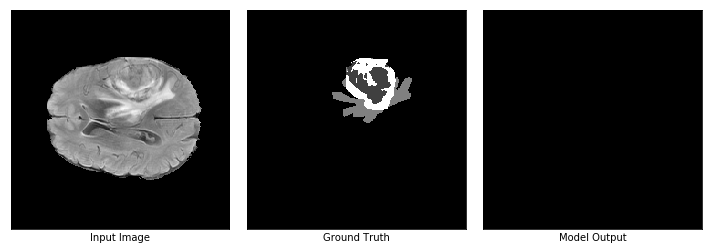

Steps: 2500, Loss:0.1550176590681076
Gradient min:-0.0006280033267103136, max:0.00017381289217155427



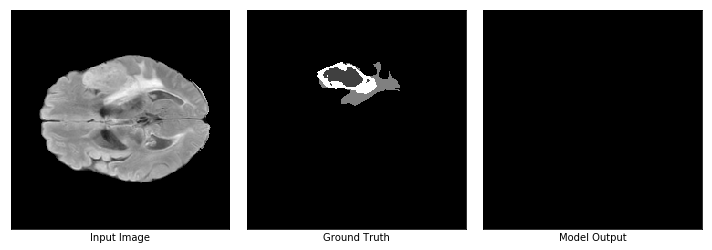

Steps: 2600, Loss:0.18551874160766602
Gradient min:-0.00037510404945351183, max:0.0001010313062579371



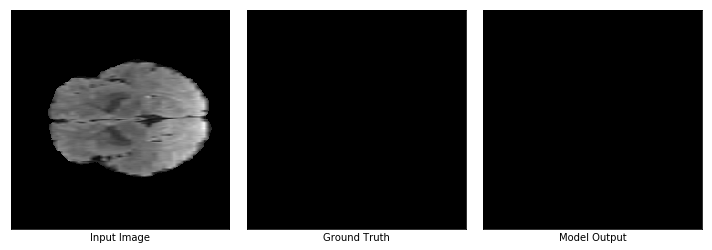

Steps: 2700, Loss:0.22019220888614655
Gradient min:-0.00041083298856392503, max:0.00011024083505617455



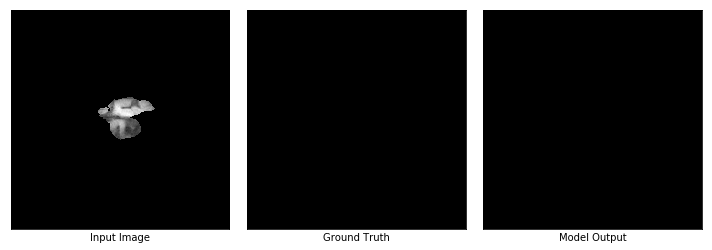

Steps: 2800, Loss:0.33575236797332764
Gradient min:-0.0003434134123381227, max:9.374919318361208e-05

HGGt1_stack.tfrecords




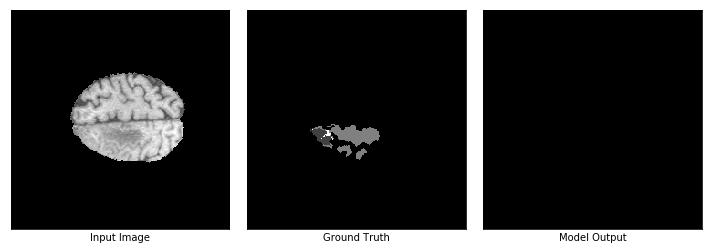

Steps: 2900, Loss:0.08539419621229172
Gradient min:-0.0002568617055658251, max:7.00857417541556e-05



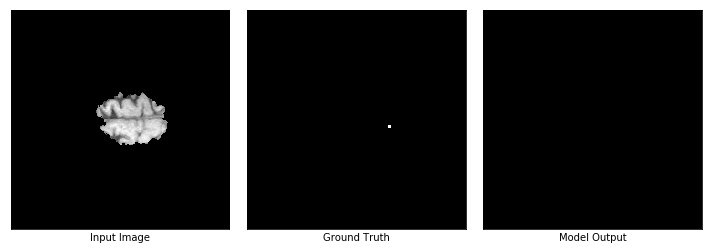

Steps: 3000, Loss:0.18719981610774994
Gradient min:-0.0002681658952496946, max:7.409560930682346e-05



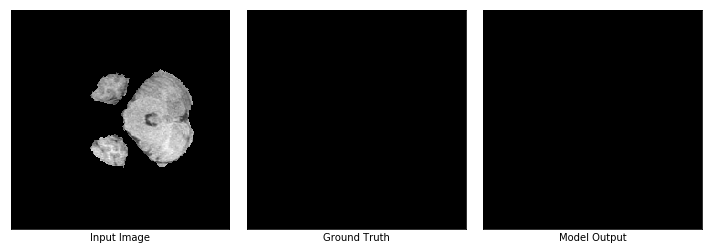

Steps: 3100, Loss:0.09052833914756775
Gradient min:-0.00019624695414677262, max:5.458134546643123e-05



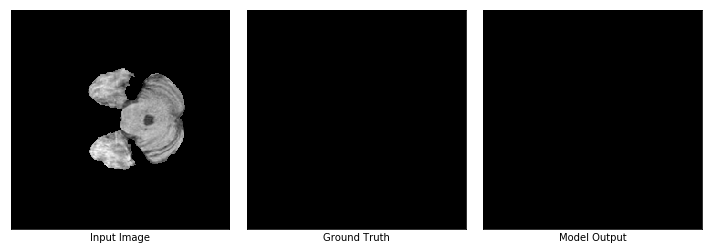

Steps: 3200, Loss:0.09281828254461288
Gradient min:-0.00018604801152832806, max:5.097974280943163e-05



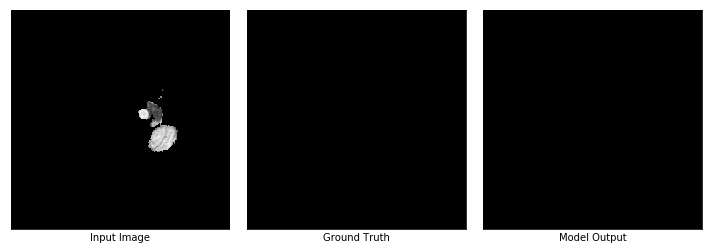

Steps: 3300, Loss:0.07887536287307739
Gradient min:-9.533738193567842e-05, max:2.5707717213663273e-05



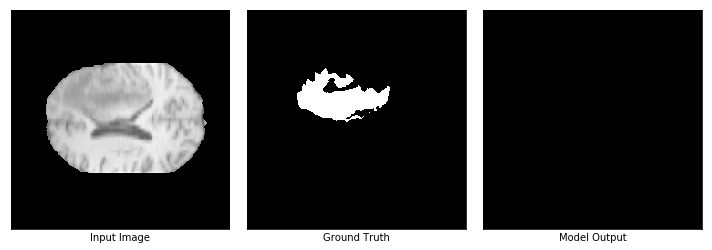

Steps: 3400, Loss:0.19553975760936737
Gradient min:-0.0001396495063090697, max:3.791855851886794e-05



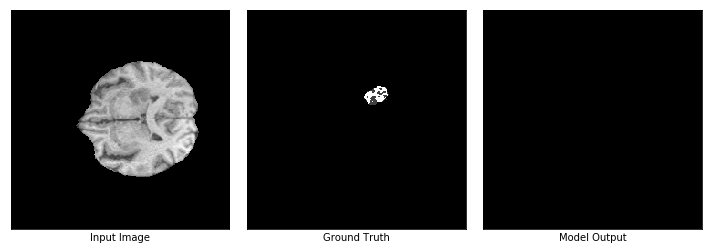

Steps: 3500, Loss:0.0649266242980957
Gradient min:-0.00010668739560060203, max:2.9699438528041355e-05



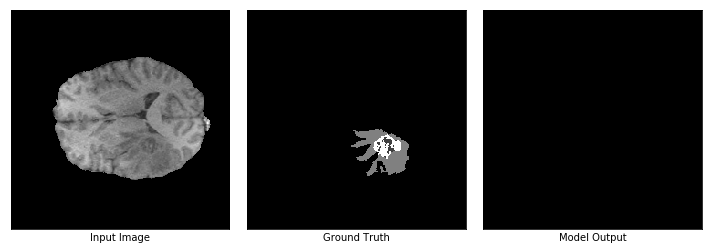

Steps: 3600, Loss:0.13375996053218842
Gradient min:-9.543416672386229e-05, max:2.619323095132131e-05



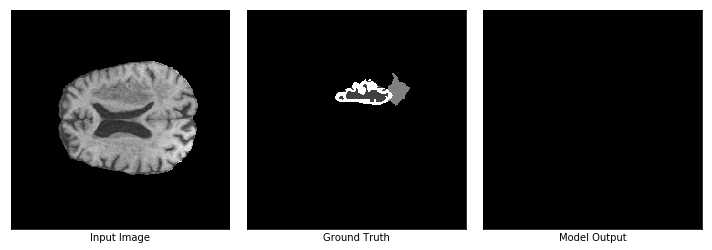

Steps: 3700, Loss:0.1621743142604828
Gradient min:-8.726344822207466e-05, max:2.4976363420137204e-05



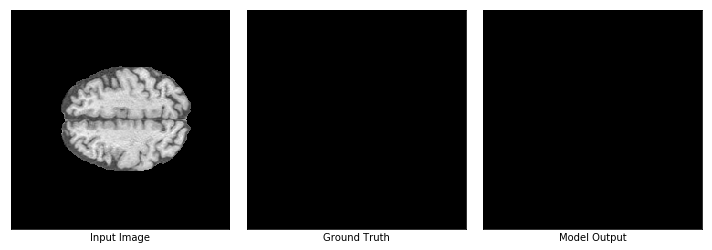

Steps: 3800, Loss:0.11833798885345459
Gradient min:-7.697880937485024e-05, max:2.1391982954810373e-05



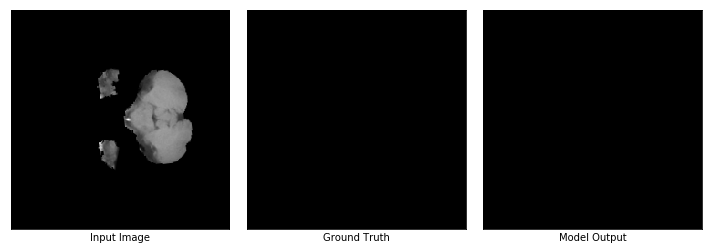

Steps: 3900, Loss:0.13597674667835236
Gradient min:-6.011945879436098e-05, max:1.6565871192142367e-05



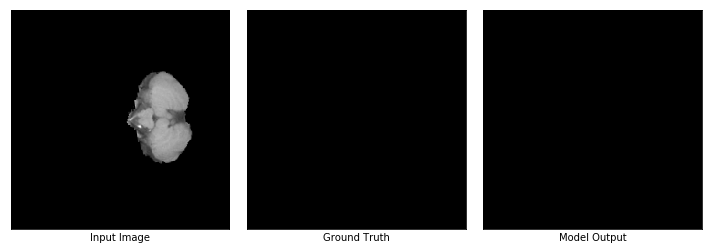

Steps: 4000, Loss:0.09853819012641907
Gradient min:-4.4518903450807557e-05, max:1.1969109436904546e-05



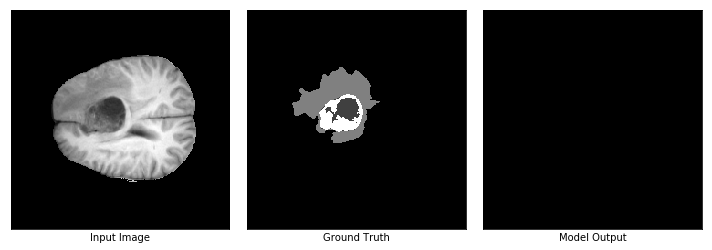

Steps: 4100, Loss:0.3412359654903412
Gradient min:-5.006156789022498e-05, max:1.381494257657323e-05



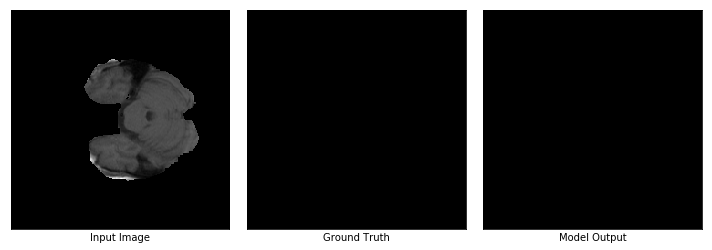

Steps: 4200, Loss:0.21550238132476807
Gradient min:-4.3313426431268454e-05, max:1.2087532923032995e-05



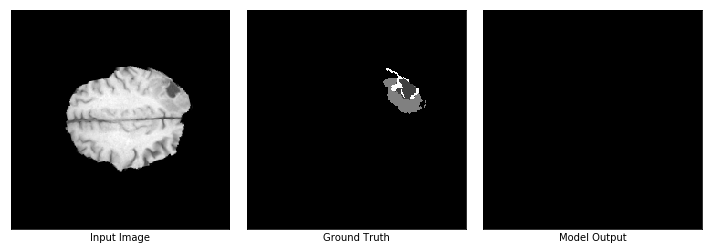

Steps: 4300, Loss:0.2855059802532196
Gradient min:-3.378043038537726e-05, max:9.363317985844333e-06



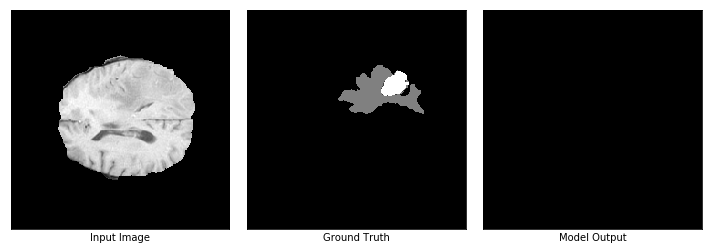

Steps: 4400, Loss:0.3050770163536072
Gradient min:-2.7221865821047686e-05, max:7.796363206580281e-06



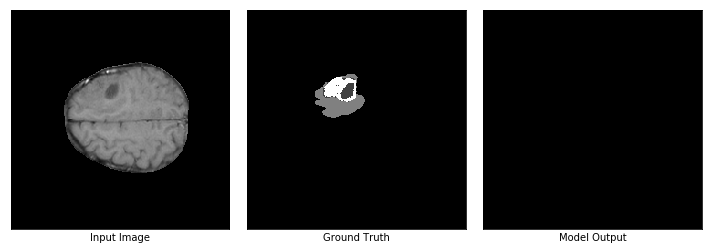

Steps: 4500, Loss:0.21177007257938385
Gradient min:-1.683378104644362e-05, max:4.890592208539601e-06



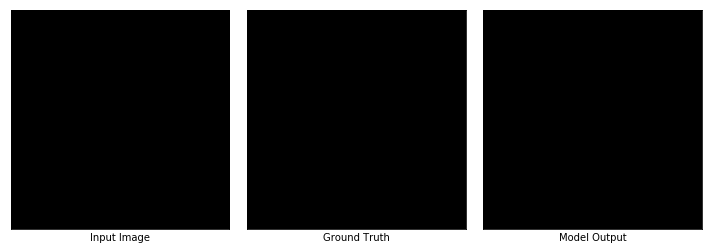

Steps: 4600, Loss:0.16837726533412933
Gradient min:-1.959407381946221e-05, max:5.626257461699424e-06



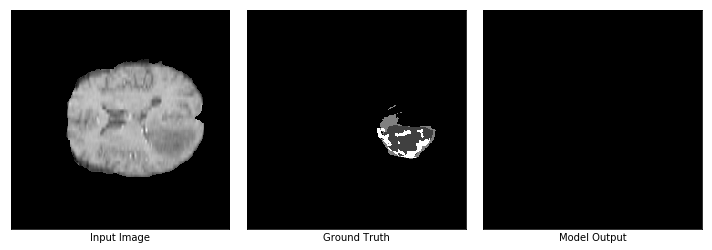

Steps: 4700, Loss:0.2657112181186676
Gradient min:-2.311586831638124e-05, max:6.6842935666500125e-06



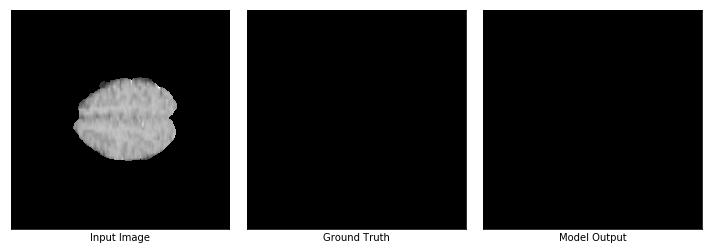

Steps: 4800, Loss:0.14304302632808685
Gradient min:-1.575845089973882e-05, max:4.682891358243069e-06



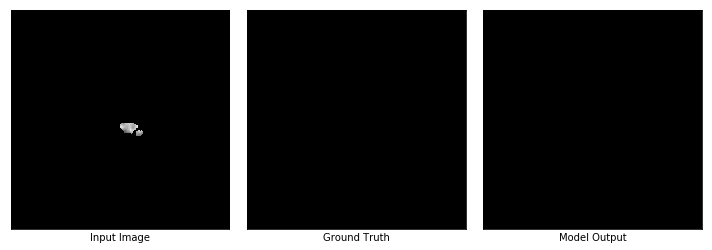

Steps: 4900, Loss:0.2225375920534134
Gradient min:-1.6203579434659332e-05, max:4.6350482989510056e-06



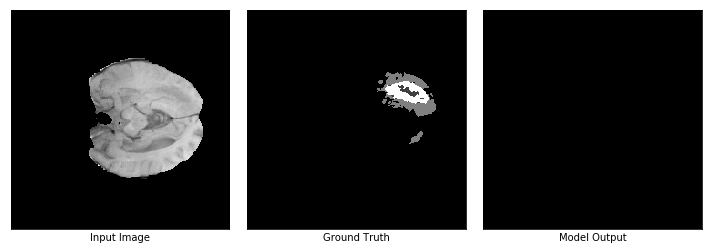

Steps: 5000, Loss:0.16985079646110535
Gradient min:-1.0762280908238608e-05, max:3.1667500479670707e-06



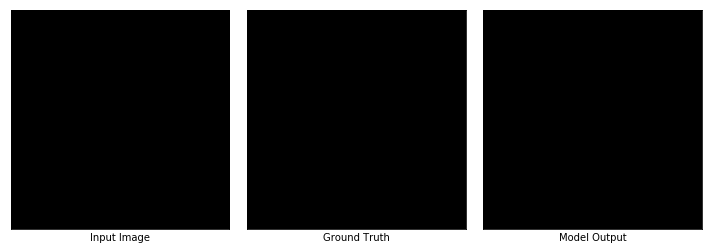

Steps: 5100, Loss:0.25729671120643616
Gradient min:-9.78754906100221e-06, max:2.6829618491319707e-06



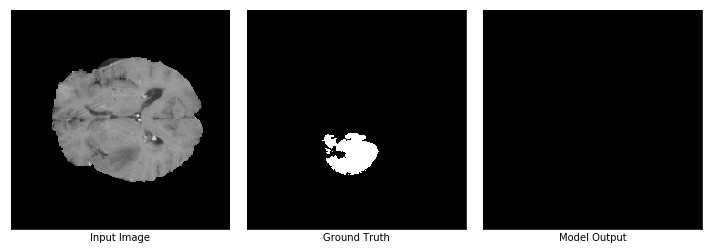

Steps: 5200, Loss:0.20090393722057343
Gradient min:-1.3181101166992448e-05, max:3.934232154279016e-06



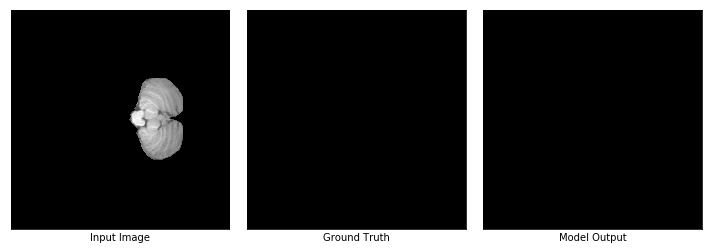

Steps: 5300, Loss:0.17896655201911926
Gradient min:-1.0023351023846772e-05, max:2.964290843010531e-06



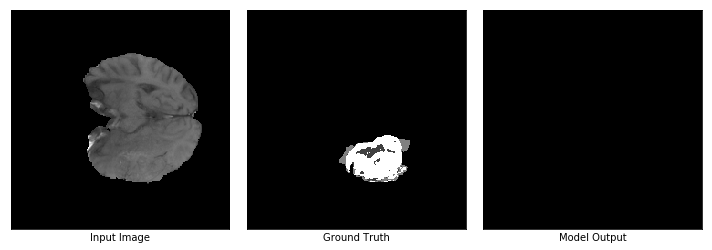

Steps: 5400, Loss:0.22307300567626953
Gradient min:-1.3991638297738973e-05, max:3.976548669015756e-06



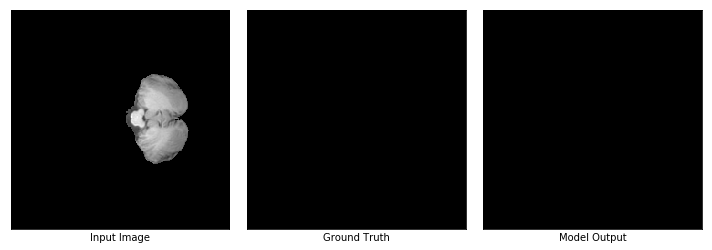

Steps: 5500, Loss:0.1647600680589676
Gradient min:-1.124029131460702e-05, max:3.2633722639729967e-06



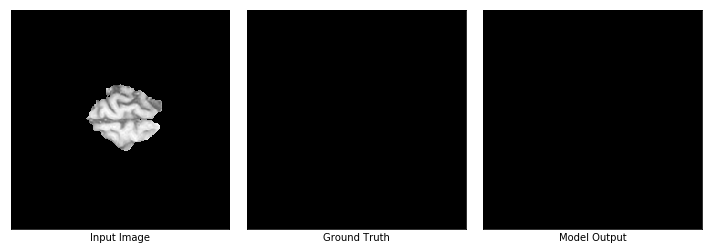

Steps: 5600, Loss:0.1579069197177887
Gradient min:-7.4272602432756685e-06, max:2.142676748917438e-06

HGGt1ce_stack.tfrecords




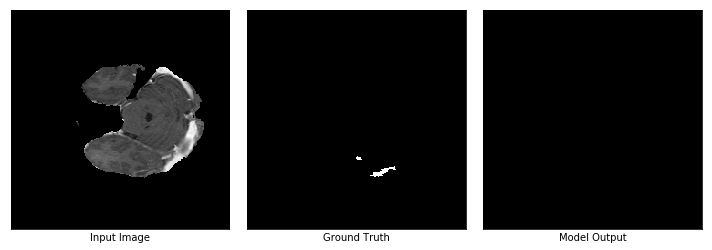

Steps: 5700, Loss:0.1583757996559143
Gradient min:-5.7855800150719006e-06, max:1.8272796751261922e-06



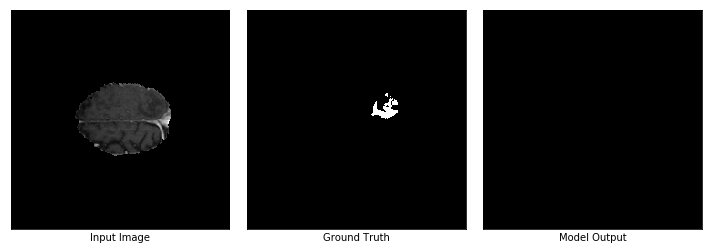

Steps: 5800, Loss:0.1241835504770279
Gradient min:-4.862876266997773e-06, max:1.4654984852313646e-06



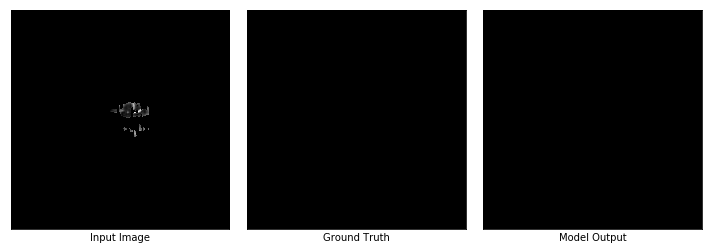

Steps: 5900, Loss:0.1857285052537918
Gradient min:-3.5843495425069705e-06, max:1.0470337201695656e-06



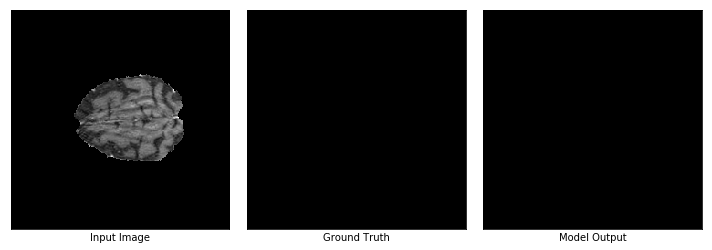

Steps: 6000, Loss:0.23287571966648102
Gradient min:-5.097073426441057e-06, max:1.6270357718894957e-06



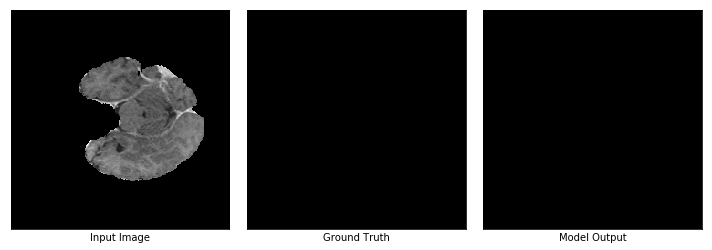

Steps: 6100, Loss:0.11781273782253265
Gradient min:-5.883973699383205e-06, max:1.8635048490978079e-06


In [ ]:
epochs = 1
max_epochs = 20
predicted_img = []
groundtruth_img = []
loss_list = []
dice_list = []
while epochs <= max_epochs:
    print("Epochs {:2d}".format(epochs))
    print()
    steps = 1
    for tf_re in sorted(os.listdir(tfrecords_read_dir)):
        print(tf_re)
        print()
        tf_dir = os.path.join(tfrecords_read_dir+tf_re)
        dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
        for image, label in dataset:
            #add last channel to fit into the model
            image = tf.reshape(image, [-1, 240, 240, 1]) #(batch_size, img_size, img_size, channel)
            #unprocessed label for plotting 
            label_plot = label
            #for simplicity label 4 will be converted to 3 for sparse encoding
            label = tf.where(label==4,3,label)
            label = tf.keras.utils.to_categorical(label, num_classes=4)
            img_seg, loss, gradients = train_fn(image, label) #training function 
            img_seg = tf.math.argmax(img_seg,-1) #map from sparse to label
#             dice_score = dice_coef(label, img_seg)
            
#             dice_list.append(dice_score) #append dice score for every every images
            
            #output
            if steps%100==0:
                input_img = [image[0], label_plot[0], img_seg[0]]
                caption = ['Input Image', 'Ground Truth', 'Model Output']
                plot_comparison(input_img, caption, n_col = 3)
                
                predicted_img.append(img_seg[0])
                groundtruth_img.append(label_plot[0])
                loss_list.append(loss)
#                 dice_coe = dice_coef(label[0], img_seg[0])
#                 print("Steps: {}, Loss:{}, Dice Score:{}".format(steps, loss, dice_coe))
                print("Steps: {}, Loss:{}".format(steps, loss))
                print("Gradient min:{}, max:{}".format(np.min(gradients[0]), np.max(gradients[0])))
            steps+=1
        print()
#         print("Average Dice Coefficient: {}".format(np.mean(np.array(dice_list))))
    epochs+=1 

---

# Model Summary

In [ ]:
# Unet.summary()